In [1]:

from occupancy.datasets.nuscenes import NuScenesDataset, NuScenesOccupancyDataset
from nuscenes.nuscenes import NuScenes
nusc = NuScenesOccupancyDataset(
    data_dir='/mnt/f/datasets/nuscenes/nuScenes-Occupancy-v0.1/', binary=False)


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import Tensor

In [12]:
def occ_shuffle(occ: Tensor, cube_size: int = 32, shuffle_rato: float = 0.2):
    total_cubes = (occ.shape[-3] // cube_size) * (occ.shape[-2] // cube_size) * (occ.shape[-1] // cube_size)
    total_shuffle = int(total_cubes * shuffle_rato)
    cubes = torch.zeros(occ.shape[0], occ.shape[1], total_cubes, cube_size, cube_size, cube_size)
    for i in range(occ.shape[-3] // cube_size):
        for j in range(occ.shape[-2] // cube_size):
            for k in range(occ.shape[-1] // cube_size):
                ind = i * (occ.shape[-2] // cube_size) * (occ.shape[-1] // cube_size) + j * (occ.shape[-1] // cube_size) + k
                cubes[:, :, ind] = occ[:, :, i * cube_size:(i + 1) * cube_size, j * cube_size:(j + 1) * cube_size, k * cube_size:(k + 1) * cube_size] 
    ind_to_shuffle = torch.randperm(total_cubes)[:total_shuffle]
    shuffle_ind = torch.randperm(total_shuffle)
    cubes[:, :, ind_to_shuffle] = cubes[:, :, ind_to_shuffle][:, :, shuffle_ind]
    shuffled = torch.zeros_like(occ)
    for i in range(occ.shape[-3] // cube_size):
        for j in range(occ.shape[-2] // cube_size):
            for k in range(occ.shape[-1] // cube_size):
                ind = i * (occ.shape[-2] // cube_size) * (occ.shape[-1] // cube_size) + j * (occ.shape[-1] // cube_size) + k
                shuffled[:, :, i*cube_size:(i+1)*cube_size, j*cube_size:(j+1)*cube_size, k*cube_size:(k+1)*cube_size] = cubes[:, :, ind]
    return shuffled
                
    

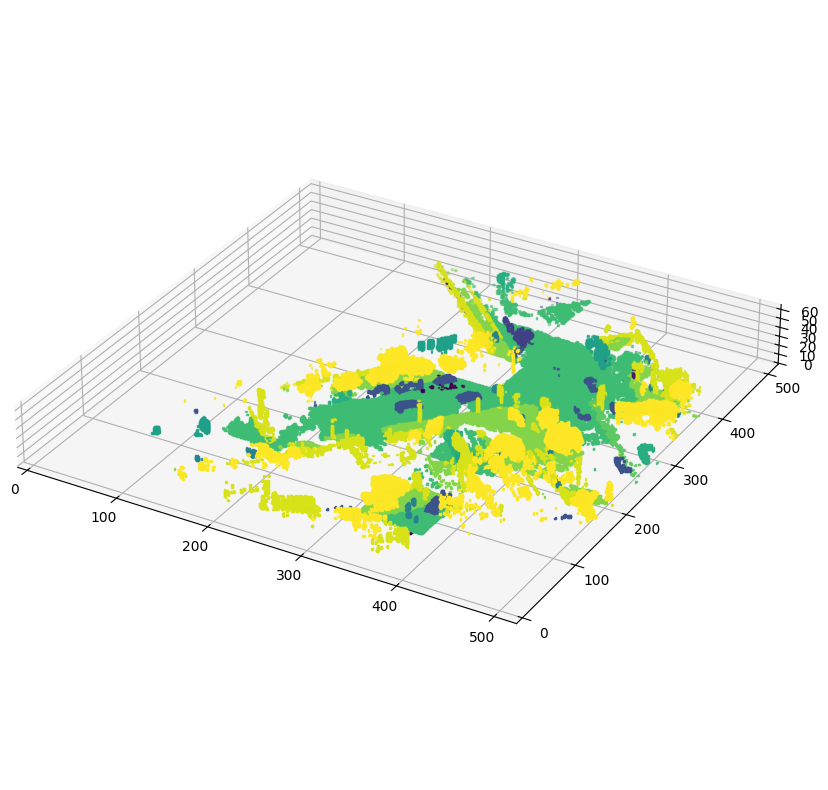

In [15]:
occ = nusc[12]
occ = F.interpolate(occ.unsqueeze(0).float(), scale_factor=2, mode='trilinear', align_corners=True).squeeze(0).argmax(0)
occ = F.one_hot(occ, num_classes=18).permute(3, 0, 1, 2).argmax(0)
occ = occ_shuffle(occ[None, None, ...], 64,0.2)[0, 0]
i,j,k = torch.where(occ)
c = occ[i,j,k]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(i,j,k, c=c, marker='s', s=1)
ax.set_xlim(0, occ.shape[-3])
ax.set_ylim(0, occ.shape[-2])
ax.set_zlim(0, occ.shape[-1])
ax.set_box_aspect((1,1,occ.shape[-1]/occ.shape[-2]))


In [ ]:
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained('stabilityai/sdxl-vae')

In [ ]:
from torch import nn, Tensor 
import torch

from occupancy.models.unet_2d import UnetEncoder2d,UnetDecoder2d
from occupancy.pipelines.autoencoderkl_2d import GaussianDistribution

class VAEAdaptor(nn.Module):
    def __init__(self, vae: AutoencoderKL, base_channels: int, num_layers: int):
        super().__init__()
        self.laten_scale = 1 / 10
        self.vae = vae
        self.vae.requires_grad_(False)
        self.encoder_layers = UnetEncoder2d(4, 1024, base_channels, 2, num_layers)
        self.decoder_layers = UnetDecoder2d(1024, 4, base_channels, 2, num_layers)
        
    def encode(self, x: Tensor) -> Tensor:
        latent = self.encoder_layers(self.vae.encode(x).latent_dist.sample())
        latent_dist = GaussianDistribution.from_latent(latent, self.laten_scale)
        return latent_dist
    
    def decode(self, x: Tensor) -> Tensor:
        return self.vae.decode(self.decoder_layers(x))

In [1]:
import torch
torch.export.export()

'2.2.0'